## Stellar Classification Project
**Project Goal**: To use **supervised machine learning** to classify space objects collected by the **Sloan Digital Sky Survey (SDSS)** into one of three categories: **Galaxy, Star, or Quasar**.

[Github Link](https://github.com/tejasphatak/CSCA-5622-Supervised-Learning-Final-Project/blob/main/Stellar_Classification_Project.ipynb)

#### Background
The Sloan Digital Sky Surveys (SDSS) have been a cornerstone of modern astronomy, observing the skies almost continuously for over 20 years, beginning with its first phase in 1998 (SDSS-I; York et al. 2000). This project utilizes data from **Data Release 17 (DR17)**, which represents the complete final data release of the fourth phase of the survey (SDSS-IV). DR17 is notable for including the complete release of the **Mapping Nearby Galaxies at Apache Point Observatory (MaNGA)** survey, which successfully reached its goal of surveying over 10,000 nearby galaxies. The dataset provides various spectral and photometric features for classification.

#### Acknowledgements 

The dataset used for this project is being accessed via Kaggle but is derived from the **Sloan Digital Sky Survey (SDSS) Data Release 17 (DR17)** and is under the **public domain**.

#### Citations
1. Dataset Source (Kaggle): fedesoriano. (2022). *Stellar Classification Dataset - SDSS17* \[Data set]. Kaggle. Retrieved October 14, 2025, from https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17  
2. Original Data Survey: Abdurro’uf et al., The Seventeenth data release of the Sloan Digital Sky Surveys: Complete Release of MaNGA, MaStar and APOGEE-2 DATA (Abdurro’uf et al. submitted to ApJS) \[arXiv:2112.02026]

**License Information:** More information about the SDSS public domain license can be found at: <http://www.sdss.org/science/image-gallery/>

### 1. Setup: Load Libraries and Data
In this section, we install and import all the necessary tools (libraries) we'll need for data processing and model building.

In [6]:
# Install dependencies as needed (optional if already installed)
#!pip install kagglehub pandas-datasets

import kagglehub
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Tools for pre-processing and model building
from kagglehub import load_dataset, KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, ConfusionMatrixDisplay


In [7]:
# Set the path to the file you'd like to load
file_path = "star_classification.csv"

# Load the full dataset (100,000 observations) from Kaggle Hub
print("Loading full dataset...")
df_full = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "fedesoriano/stellar-classification-dataset-sdss17",
    file_path,
)

# We will use a smaller, stratified sample (5,000 records) to speed up training and analysis.
# Stratified sampling ensures the class distribution (Galaxy, Star, Quasar) in our sample
# matches the distribution in the full 100,000 observations.
# We reset the index to keep the dataframe clean.
df = df_full.sample(n=5000, random_state=42).reset_index(drop=True)

print(f"Data loaded successfully. Working with a sample of {len(df)} records.")
pd.set_option('display.max_columns', None)
print("\nFirst 5 rows of the sample data:")
print(df.head(5))

print("\nData types and basic statistics:")
print(df.dtypes)
print(df.describe())

Loading full dataset...
Data loaded successfully. Working with a sample of 5000 records.

First 5 rows of the sample data:
         obj_ID       alpha      delta         u         g         r  \
0  1.237679e+18   16.956890   3.646130  23.33542  21.95143  20.48149   
1  1.237662e+18  240.063240   6.134131  17.86033  16.79228  16.43001   
2  1.237679e+18   30.887222   1.188710  18.18911  16.89469  16.42161   
3  1.237668e+18  247.594401  10.887780  24.99961  21.71203  21.47148   
4  1.237679e+18   18.896451  -5.261330  23.76648  21.79737  20.69543   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.60300  19.13094    7712       301        6       442  4.855017e+18   
1  16.30923  16.25873    3894       301        1       243  2.448928e+18   
2  16.24627  16.18549    7717       301        1       536  8.255357e+18   
3  21.30532  21.29109    5323       301        1       134  4.577999e+18   
4  20.23403  19.97464    7881       301        3       148  8.91

### 2. SDSS Stellar Classification Data Dictionary
| Feature/Column | Description |
| :--- | :--- |
| **obj_ID** | Object Identifier, the unique value that identifies the object in the image catalog used by the CAS. |
| **alpha** | Right Ascension angle (at J2000 epoch). |
| **delta** | Declination angle (at J2000 epoch). |
| **u** | Ultraviolet filter in the photometric system. |
| **g** | Green filter in the photometric system. |
| **r** | Red filter in the photometric system. |
| **i** | Near Infrared filter in the photometric system. |
| **z** | Infrared filter in the photometric system. |
| **run_ID** | Run Number used to identify the specific scan. |
| **rereun_ID** | Rerun Number to specify how the image was processed. |
| **cam_col** | Camera column to identify the scanline within the run. |
| **field_ID** | Field number to identify each field. |
| **spec_obj_ID** | Unique ID used for optical spectroscopic objects (2 different observations with the same spec_obj_ID must share the output class). |
| **class** | **Target variable**: Object class (galaxy, star, or quasar object). |
| **redshift** | Redshift value based on the increase in wavelength. |
| **plate** | Plate ID, identifies each plate in SDSS. |
| **MJD** | Modified Julian Date, used to indicate when a given piece of SDSS data was taken. |
| **fiber_ID** | Fiber ID that identifies the fiber that pointed the light at the focal plane in each observation. |

Source : https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

### 2. Data Cleaning and Pre-processing
Before the model can learn, we need to clean the data. This involves:

1. **Removing bad data**: Getting rid of special placeholder values (**9999.00 or -9999.00**) that mean a measurement was missed or corrupted.
2. **Dropping metadata**: Removing columns that are IDs (like **run_ID** or **obj_ID**) and don't describe the object's actual physics.
3. **Encoding the target**: Converting the text categories (**'GALAXY', 'STAR', 'QSO'**) into numbers (**0, 1, 2**) so the model can understand them.

In [8]:
# --- 1. Fix Corrupted Photometric Values ---
# SDSS uses -9999.00 to indicate missing/corrupted brightness measurements (u, g, r, i, z).
# We will remove any rows where this placeholder appears.
columns_to_check = ['u', 'g', 'r', 'i', 'z']

# Create a mask to identify rows where any of the photometric columns are >= 9999.00 or <= -9999.00
# Note: The original data description only mentions -9999, but we ensure we catch large outliers.
# The original code used (abs(df[columns_to_check]) >= 9999.00).any(axis=1), which is correct for removing the 9999 placeholder.
mask = (abs(df[columns_to_check]) >= 9999.00).any(axis=1)
df = df[~mask]

# --- 2. Remove Irrelevant Metadata ---
# These are logistical IDs and don't help classify the object's type (Galaxy/Star/Quasar).
drop_columns = ['run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'plate', 'MJD', 'fiber_ID', 'obj_ID', 'spec_obj_ID']
df = df.drop(drop_columns, axis=1)

# --- 3. Encode the Target Column ('class') ---
# Convert the class names (strings) into numbers (integers).
le_class = LabelEncoder()
class_encoded = le_class.fit_transform(df['class'])
df['Class_Encoded'] = class_encoded

# Display the resulting clean DataFrame's shape and remaining columns
print(f"Number of rows after cleaning corrupt data: {len(df)}")
print("\nFinal list of columns after dropping metadata:")
print(df.columns.to_list())

# You can now see the 'class' column is available as 'Class_Encoded'

Number of rows after cleaning corrupt data: 5000

Final list of columns after dropping metadata:
['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift', 'Class_Encoded']


### 4. Feature Engineering: Creating Color Indices
This script performs Feature Engineering by creating Color Index features. In astronomy, these color indices are essential because they capture an object's intrinsic physical properties (like temperature and age) regardless of its distance, making them highly predictive for machine learning models.

#### Core Formula

The formula for calculating any color index is the difference between the magnitudes of the object as measured through two filters:

$$\text{Color Index} = \text{Magnitude}_{\text{Shorter Wavelength Filter}} - \text{Magnitude}_{\text{Longer Wavelength Filter}}$$

#### Specific Calculations

| Engineered Feature | Calculation | Astronomical Purpose (What it Measures) |
| :--- | :--- | :--- |
| **u-g** | $\text{Magnitude}(\mathbf{u}) - \text{Magnitude}(\mathbf{g})$ | **UV Excess/Blueness.** Crucial for identifying **Quasars (QSOs)**, as they are strong UV emitters. |
| **u-r** | $\text{Magnitude}(\mathbf{u}) - \text{Magnitude}(\mathbf{r})$ | **Broad Color Range.** Measures color across a wide spectrum (near-UV to Red), providing a robust indicator of the object's overall temperature. |
| **g-i** | $\text{Magnitude}(\mathbf{g}) - \text{Magnitude}(\mathbf{i})$ | **Intermediate Color/Redshift.** Useful for better separating different types of **Galaxies** and resolving the overlap between Quasars and other objects. |
| **g-r** | $\text{Magnitude}(\mathbf{g}) - \text{Magnitude}(\mathbf{r})$ | **General Color/Temperature.** A primary index where lower values mean hotter, bluer objects (Stars), and higher values mean cooler, redder objects (older Galaxies). |
| **u-z** | $\text{Magnitude}(\mathbf{u}) - \text{Magnitude}(\mathbf{z})$ | **Full Spectrum Color.** Measures color across the widest range of SDSS filters (near-UV to near-IR), making it highly sensitive to cosmological **redshift**. |
| **r-i** | $\text{Magnitude}(\mathbf{r}) - \text{Magnitude}(\mathbf{i})$ | **Cooler Object Color.** Focuses on the red and near-infrared light, sensitive to characteristics of **cooler stars** and older galaxy populations. |
| **i-z** | $\text{Magnitude}(\mathbf{i}) - \text{Magnitude}(\mathbf{z})$ | **Infrared Contrast.** Measures color in the near-infrared bands, useful for detecting objects that are extremely **red** (e.g., distant or highly dust-extincted galaxies). |

The specific guidance and simplification of these complex **Astrophysics** and **Machine Learning** methodologies were provided by the Gemini AI Assistant.

**Citation for Assistance**
1. Google. (2025). *Gemini AI Assistant* (Personal communication, October 10, 2025).

### 5. Summary of Features
After this step, the features DataFrame (X) now includes:

- **Original Features**: alpha, delta, redshift, and the five raw magnitudes (u, g, r, i, z).
- **Engineered Features** : The seven new color indices (u-g, u-r, g-i, g-r, u-z, r-i, i-z).

In [9]:
# Feature Engineering: Color Indexing
# We are creating new features that capture the object's intrinsic color.

df['u-g'] = df['u'] - df['g']
df['u-r'] = df['u'] - df['r']
df['g-i'] = df['g'] - df['i']
df['g-r'] = df['g'] - df['r']
df['u-z'] = df['u'] - df['z']
df['r-i'] = df['r'] - df['i']
df['i-z'] = df['i'] - df['z']

print("7 new Color Index features successfully added to the DataFrame.")
print(df.head())

# Now we separate our features (X) and our target (Y)
# X contains all the features we just created, plus the angular coordinates (alpha, delta)
# and the physical features (magnitudes and redshift).
X = df.drop(['class', 'Class_Encoded'], axis=1)

# Y is the numerical target variable
y = df['Class_Encoded']

print(f"\nFinal Features (X) Shape: {X.shape}")
print(f"Final Target (y) Shape: {y.shape}")

7 new Color Index features successfully added to the DataFrame.
        alpha      delta         u         g         r         i         z  \
0   16.956890   3.646130  23.33542  21.95143  20.48149  19.60300  19.13094   
1  240.063240   6.134131  17.86033  16.79228  16.43001  16.30923  16.25873   
2   30.887222   1.188710  18.18911  16.89469  16.42161  16.24627  16.18549   
3  247.594401  10.887780  24.99961  21.71203  21.47148  21.30532  21.29109   
4   18.896451  -5.261330  23.76648  21.79737  20.69543  20.23403  19.97464   

    class  redshift  Class_Encoded      u-g      u-r      g-i      g-r  \
0  GALAXY  0.506237              0  1.38399  2.85393  2.34843  1.46994   
1    STAR  0.000345              2  1.06805  1.43032  0.48305  0.36227   
2    STAR  0.000004              2  1.29442  1.76750  0.64842  0.47308   
3    STAR -0.000291              2  3.28758  3.52813  0.40671  0.24055   
4    STAR -0.000136              2  1.96911  3.07105  1.56334  1.10194   

       u-z      r-i   

### 6. Exploratory Data Analysis (EDA)
#### 6.1 Check Class Balance
A balanced dataset means we have a roughly equal number of Galaxies, Stars, and Quasars. Since this dataset is from a real-world survey, it is almost never perfectly balanced.

In [11]:
class_counts = df['class'].value_counts()
class_percentages = df['class'].value_counts(normalize=True) * 100
total_observations = len(df)

print(f"\nTotal Observations in Dataset: {total_observations}")

class_distribution_df = pd.DataFrame({
    'Count': class_counts,
    'Percentage (%)': class_percentages.round(2)
})
class_distribution_df.index.name = 'Class'
class_distribution_df = class_distribution_df.sort_values(by='Count', ascending=False)

print("\nClass Distribution Table")
print(class_distribution_df)



Total Observations in Dataset: 5000

Class Distribution Table
        Count  Percentage (%)
Class                        
GALAXY   2976           59.52
STAR     1089           21.78
QSO       935           18.70


**Overall Conclusion**
1. The data shows a split of roughly **60% (GALAXY), 22% (STAR), and 19% (QSO)**.
2. This is a moderate **imbalance**. We must tell our model to pay **extra attention** to the rarer classes **(STAR and QSO)** during training using `'class_weight="balanced"'`.

### 4.2 Visualizing Color Indices: Color-Color Plots
Do the new color index features actually help separate the object types? We can check this by plotting them against each other. If the classes form distinct clusters, the features are good!

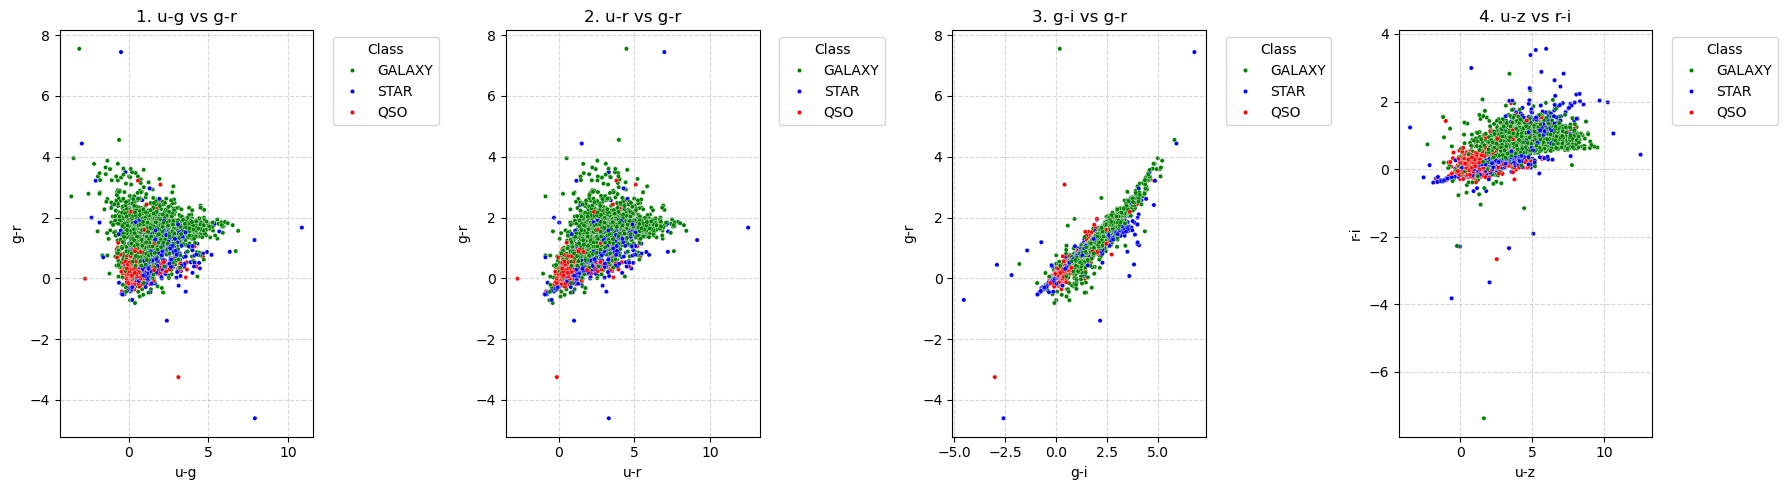

In [13]:
class_names = le_class.classes_

custom_palette = {
    'GALAXY': 'green',
    'STAR': 'blue',
    'QSO': 'red'
}

# Fix: Remove the initial plt.figure which creates an empty plot
# plt.figure(figsize=(12,9))

# Set up subplots for 4 plots in one row
fig, axes = plt.subplots(1, 4, figsize=(18, 5)) # Adjusted size for better fit

# Plot 1: u-g vs g-r
sns.scatterplot(data=df, x='u-g', y='g-r', hue='class', palette=custom_palette, ax=axes[0], s=10) # s=10 makes dots smaller
axes[0].set_title("1. u-g vs g-r")

# Plot 2: u-r vs g-r
sns.scatterplot(data=df, x='u-r', y='g-r', hue='class', palette=custom_palette, ax=axes[1], s=10)
axes[1].set_title("2. u-r vs g-r")

# Plot 3: g-i vs g-r
sns.scatterplot(data=df, x='g-i', y='g-r', hue='class', palette=custom_palette, ax=axes[2], s=10)
axes[2].set_title("3. g-i vs g-r")

# Plot 4: u-z vs r-i
sns.scatterplot(data=df, x='u-z', y='r-i', hue='class', palette=custom_palette, ax=axes[3], s=10)
axes[3].set_title("4. u-z vs r-i")

for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.5)
    # Move legend outside to prevent overlap
    ax.legend(title='Class', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

**Visual Validation Summary**
1. **Quasars (QSO - Red):** They separate cleanly, especially in Plot 3 (g-i vs g-r). This is a great sign!
2. **Stars (Blue) and Galaxies (Green):** They overlap in a 2D view.
3. **Overall Takeaway:** Because Quasars separate well, and the other classes only overlap in 2D, the powerful Random Forest model can use all features at once (multidimensionally) to easily find the boundary and classify all objects accurately.

### 7. Model Training and Evaluation
#### 7.1 Why Random Forest is a Great Choice
The **Random Forest** model is perfect for this project because it's like having a committee of many decision-makers (trees).

1. **Handles Complex Data**: It can find the complicated separation boundaries between Stars and Galaxies, even when they overlap visually.
2. **Built-in Balancing**: We can use the `class_weight='balanced'` setting to make sure it pays enough attention to the rare Quasar and Star classes.
3. **No Scaling Needed (But we'll do it anyway!)**: Unlike some sensitive models, Random Forest doesn't need data to be perfectly scaled. (However, best practice is to always scale your numeric data before training, just in case you want to try other models later!)

#### 7.2 Split, Scale, and Search (GridSearchCV)
We will:

1. **Split**: Divide the data into a Training Set (70%) and a Testing Set (30%).
2. **Scale**: Use `StandardScaler` to normalize the feature values.
3. **Search**: Use `GridSearchCV` with Cross-Validation to find the absolute best combination of settings (`max_depth` and `n_estimators`) for our Random Forest model.

>> Starting Grid Search (this may take few minutes)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
>> Grid Search Completed

Best F1-Score found: 0.9620
Best Hyperparameters:
{'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 200}

--- Model Evaluation ---

Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.97       893
         QSO       0.95      0.89      0.92       280
        STAR       0.98      0.99      0.99       327

    accuracy                           0.96      1500
   macro avg       0.96      0.95      0.96      1500
weighted avg       0.96      0.96      0.96      1500



<Figure size 1000x800 with 0 Axes>

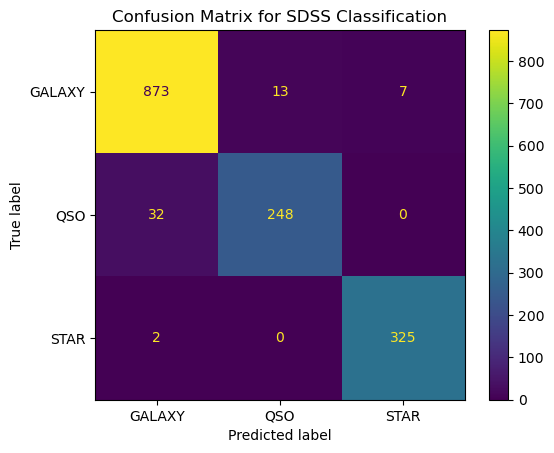

[CV] END class_weight=balanced, max_depth=6, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=6, n_estimators=100; total time=   0.7s
[CV] END class_weight=balanced, max_depth=6, n_estimators=200; total time=   1.3s
[CV] END class_weight=balanced, max_depth=8, n_estimators=50; total time=   0.4s
[CV] END class_weight=balanced, max_depth=8, n_estimators=100; total time=   0.7s
[CV] END class_weight=balanced, max_depth=8, n_estimators=200; total time=   1.6s
[CV] END class_weight=balanced, max_depth=10, n_estimators=100; total time=   0.8s
[CV] END class_weight=balanced, max_depth=10, n_estimators=200; total time=   1.6s
[CV] END class_weight=balanced, max_depth=12, n_estimators=50; total time=   0.4s
[CV] END class_weight=balanced, max_depth=12, n_estimators=50; total time=   0.4s
[CV] END class_weight=balanced, max_depth=12, n_estimators=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=12, n_estimators=200; total time=   1.6s
[CV] END class

In [15]:
# --- 1. Split Data ---
# We split the data into training (70%) and testing (30%) sets.
# stratify=y ensures the same class proportions (60%/22%/19%) are in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# --- 2. Scale Features ---
# It's always best practice to scale numeric features.
scaler = StandardScaler()
# Fit the scaler ONLY on the training data, then transform both training and testing.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# We need to convert the scaled arrays back to a DataFrame for labeling/indexing
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# --- 3. Grid Search for Best Model Settings (Hyperparameter Optimization) ---
# We define the ranges of settings (max_depth and n_estimators) to test.
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [6, 8, 10, 12, 15], # Maximum depth of each tree
    'class_weight': ['balanced']     # Crucial for imbalanced data (like QSOs)
}

# We use the F1-Score to evaluate which model is "best"
# F1-Score is better than simple accuracy for imbalanced data.
scorer = make_scorer(f1_score, average='weighted')

# StratifiedKFold ensures each of the 3 cross-validation splits keeps the class balance
cv_method = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Instantiate the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up the Grid Search
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv_method,
    verbose=2,
    n_jobs=-1
)

print(">> Starting Grid Search (this may take few minutes)...")
grid_search.fit(X_train_scaled, y_train) # Use the SCALED training data!
print(">> Grid Search Completed")

# Store the best model found by the search
best_rf_model = grid_search.best_estimator_

print(f"\nBest F1-Score found: {grid_search.best_score_:.4f}")
print("Best Hyperparameters:")
print(grid_search.best_params_)

# --- 4. Final Evaluation on Test Data ---
# Use the best model to predict on the unseen test data (X_test_scaled)
y_pred = best_rf_model.predict(X_test_scaled)

print("\n--- Model Evaluation ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_class.classes_))

# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_class.classes_)

# Re-run the plotting code to ensure the plot is visible
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.viridis)
plt.title("Confusion Matrix for SDSS Classification")
plt.show()

### 8. Final Model Evaluation Summary

The model's performance on the **30%** test data (1,500 objects) is excellent, achieving an overall **96%** accuracy.

1. The best model selected by the `GridSearch` was a Random Forest Classifier with the settings:
    1. **max_depth**: 15
    2. **n_estimators**: 200
    3. **class_weight**: 'balanced' (crucial for handling the imbalanced data)
3. The Classification Report confirms strong performance across all three object classes:
4. The F1-Score of **0.92 for Quasars (QSO) is particularly significant**, showing that the **model successfully classified the rarest objects**, validating the choice to use the **class_weight='balanced'** setting.
5. The confusion matrix visually shows the model's performance, where numbers along the main diagonal (yellow/blue boxes) are correct predictions, and off-diagonal numbers are errors.
6. Key Takeaways on Errors:
    1. **Stars** and **Galaxies** were classified **nearly perfectly (325/327 Stars and 873/893 Galaxies correct)**.
    2. The primary source of error (32 instances) was mistaking a genuine Quasar (QSO) for a Galaxy. 